In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import argparse
import sys
sys.path.append('/content/drive/MyDrive/Image-Denoising-with-Deep-CNNs/src/')
import torch
import numpy as np
import matplotlib.pyplot as plt
from data import NoisyBSDSDataset
from data import NoisyBSDSDatasetMult
from argument import parse
from model import DnCNN, UDnCNN, DUDnCNN
import nntools as nt
from utils import DenoisingStatsManager, plot
import torch.utils.data as td
import os
import torchvision as tv
from PIL import Image


DnCNN auf Mult rauschen

Running experiment 1/3
C=64, D=6, M=1, epochs=600
Train set: NoisyBSDSDatasetMultCorrected, Test set: NoisyBSDSDatasetMultCorrected
Start/Continue training from epoch 0
PSNR: 15.56 dB
Epoch 1 | Time: 9.90s | Training Loss: 0.168536 | Evaluation Loss: 0.102067
PSNR: 16.47 dB
Epoch 2 | Time: 10.07s | Training Loss: 0.093240 | Evaluation Loss: 0.083009
PSNR: 16.28 dB
Epoch 3 | Time: 10.55s | Training Loss: 0.078749 | Evaluation Loss: 0.078540
PSNR: 16.82 dB
Epoch 4 | Time: 10.85s | Training Loss: 0.067545 | Evaluation Loss: 0.072074
PSNR: 18.03 dB
Epoch 5 | Time: 10.40s | Training Loss: 0.060837 | Evaluation Loss: 0.056357
PSNR: 16.38 dB
Epoch 6 | Time: 9.55s | Training Loss: 0.057100 | Evaluation Loss: 0.081038
PSNR: 18.98 dB
Epoch 7 | Time: 9.72s | Training Loss: 0.054062 | Evaluation Loss: 0.047023
PSNR: 17.82 dB
Epoch 8 | Time: 9.76s | Training Loss: 0.050092 | Evaluation Loss: 0.058890
PSNR: 19.32 dB
Epoch 9 | Time: 10.27s | Training Loss: 0.048038 | Evaluation Loss: 0.044235
PSNR: 1

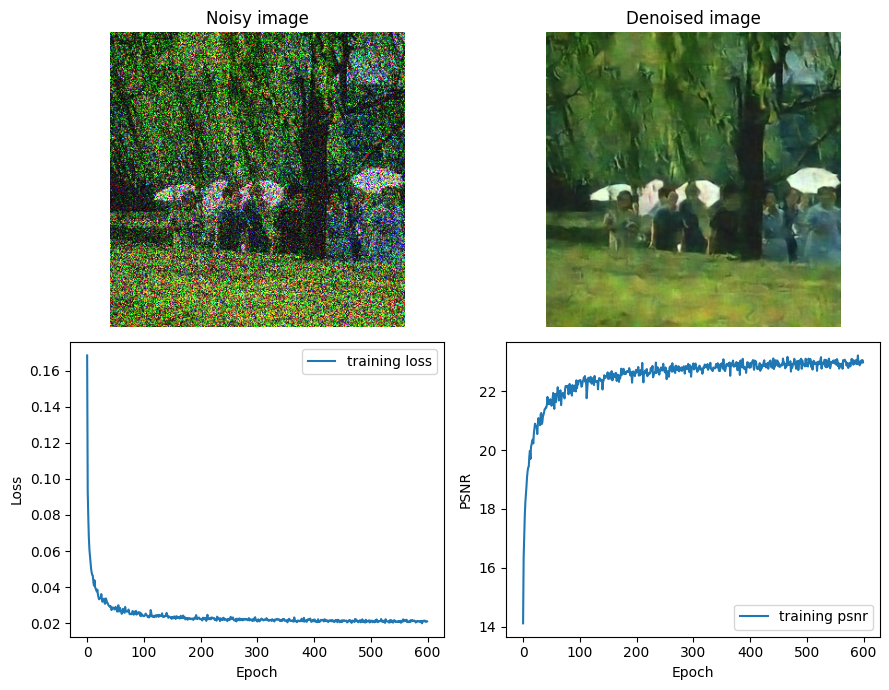

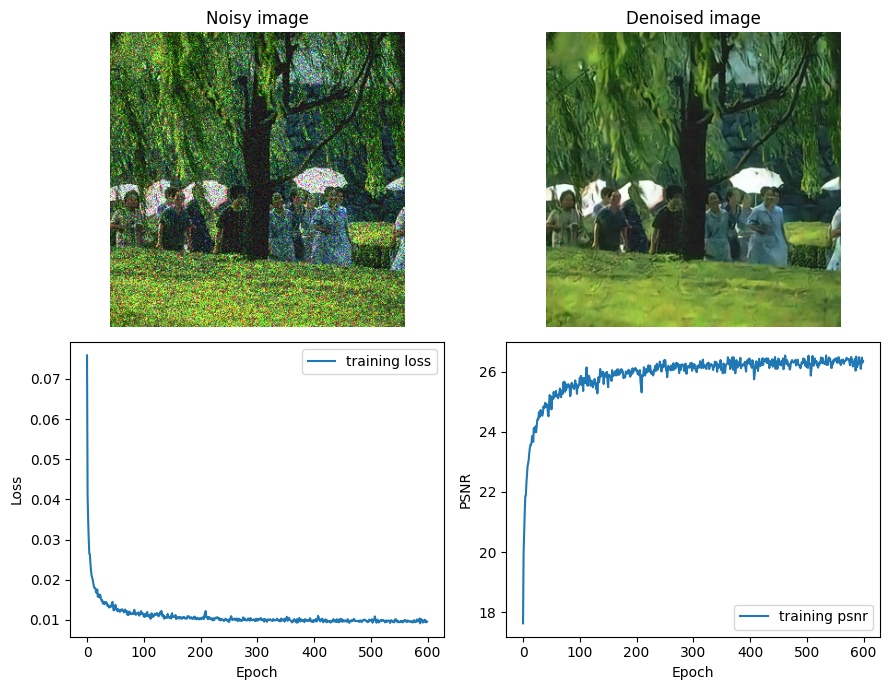

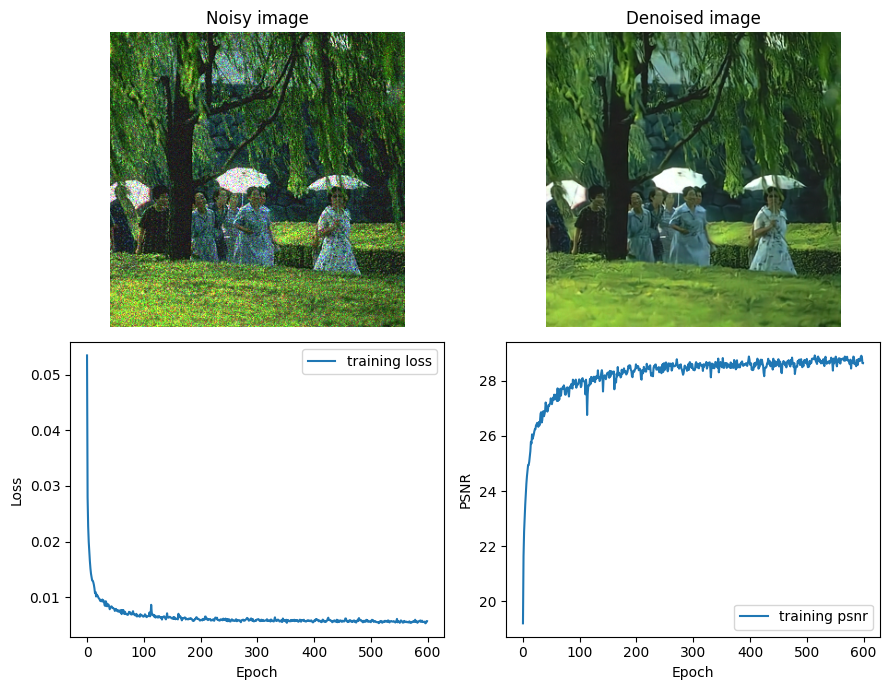

In [ ]:
class NoisyBSDSDatasetMultCorrected(td.Dataset):
    def __init__(self, root_dir, mode='train', image_size=(180, 180), M=1):
        super(NoisyBSDSDatasetMultCorrected, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.M = M
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')

        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])
        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])

        clean_01 = tv.transforms.ToTensor()(clean)

        noise = torch.distributions.Gamma(
            concentration=torch.tensor(float(self.M)),
            rate=torch.tensor(float(self.M))
        ).sample(clean_01.shape)

        noisy_01 = clean_01 * noise
        noisy_01 = torch.clamp(noisy_01, 0, 1)

        clean = clean_01 * 2 - 1
        noisy = noisy_01 * 2 - 1

        return noisy, clean


configs = [
    {'C': 64, 'D': 6, 'M': 1,  'epochs': 600, 'train_set': NoisyBSDSDatasetMultCorrected, 'test_set': NoisyBSDSDatasetMultCorrected},
    {'C': 64, 'D': 6, 'M': 4,  'epochs': 600, 'train_set': NoisyBSDSDatasetMultCorrected, 'test_set': NoisyBSDSDatasetMultCorrected},
    {'C': 64, 'D': 6, 'M': 10, 'epochs': 600, 'train_set': NoisyBSDSDatasetMultCorrected, 'test_set': NoisyBSDSDatasetMultCorrected},
]


for i, config in enumerate(configs):
    print("="*60)
    print(f"Running experiment {i+1}/{len(configs)}")
    print(f"C={config['C']}, D={config['D']}, M={config['M']}, epochs={config['epochs']}")
    print(f"Train set: {config['train_set'].__name__}, Test set: {config['test_set'].__name__}")
    print("="*60)

    class Args():
        def __init__(self):
            self.root_dir = '/content/drive/MyDrive/Image-Denoising-with-Deep-CNNs/dataset/BSDS300/images'
            self.output_dir = '/content/drive/MyDrive/Image-Denoising-with-Deep-CNNs/checkpoints/mult_M' + str(config['M']) + '/'
            self.D = config['D']
            self.C = config['C']
            self.plot = False
            self.num_epochs = config['epochs']
            self.model = 'dncnn'
            self.lr = 1e-3
            self.image_size = (180, 180)
            self.test_image_size = (320, 320)
            self.batch_size = 4
            self.M = config['M']

    args = Args()
    args.plot = True
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    np.random.seed(60)
    torch.manual_seed(60)
    train_set = config['train_set'](
            args.root_dir, image_size=args.image_size, M=args.M)
    test_set = config['test_set'](
            args.root_dir, mode='test', image_size=args.test_image_size, M=args.M)

    if args.model == 'dncnn':
        net = DnCNN(args.D, C=args.C).to(device)
    elif args.model == 'udncnn':
        net = UDnCNN(args.D, C=args.C).to(device)
    elif args.model == 'dudncnn':
        net = DUDnCNN(args.D, C=args.C).to(device)
    else:
        raise NameError('Please enter: dncnn, udncnn, or dudncnn')

    adam = torch.optim.Adam(net.parameters(), lr=args.lr)
    stats_manager = DenoisingStatsManager()

    exp = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=args.batch_size,
                           output_dir=args.output_dir, perform_validation_during_training=True)

    if args.plot:
        fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
        exp.run(num_epochs=args.num_epochs, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                    noisy=test_set[73][0]))
    else:
        exp.run(num_epochs=args.num_epochs)